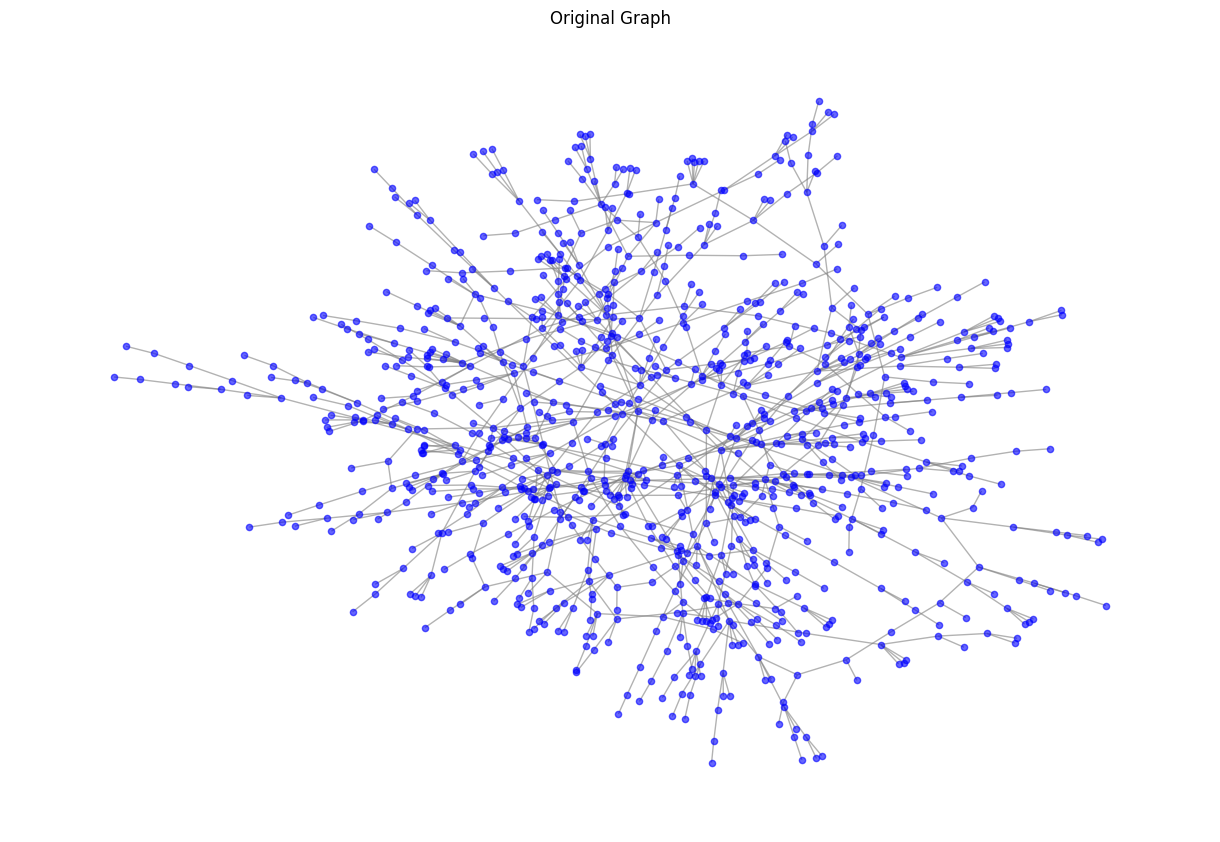


Top 10 Nodes Without Optimization:
Node: 1, Score: 3.8
Node: 0, Score: 3.4431746202061118
Node: 5, Score: 2.808421093474931
Node: 3, Score: 2.5773132911737924
Node: 2, Score: 2.471228927237215
Node: 4, Score: 2.1924092738143814
Node: 24, Score: 1.9432197000982139
Node: 6, Score: 1.8344454370246788
Node: 96, Score: 1.8097718070716933
Node: 49, Score: 1.7800504682939453


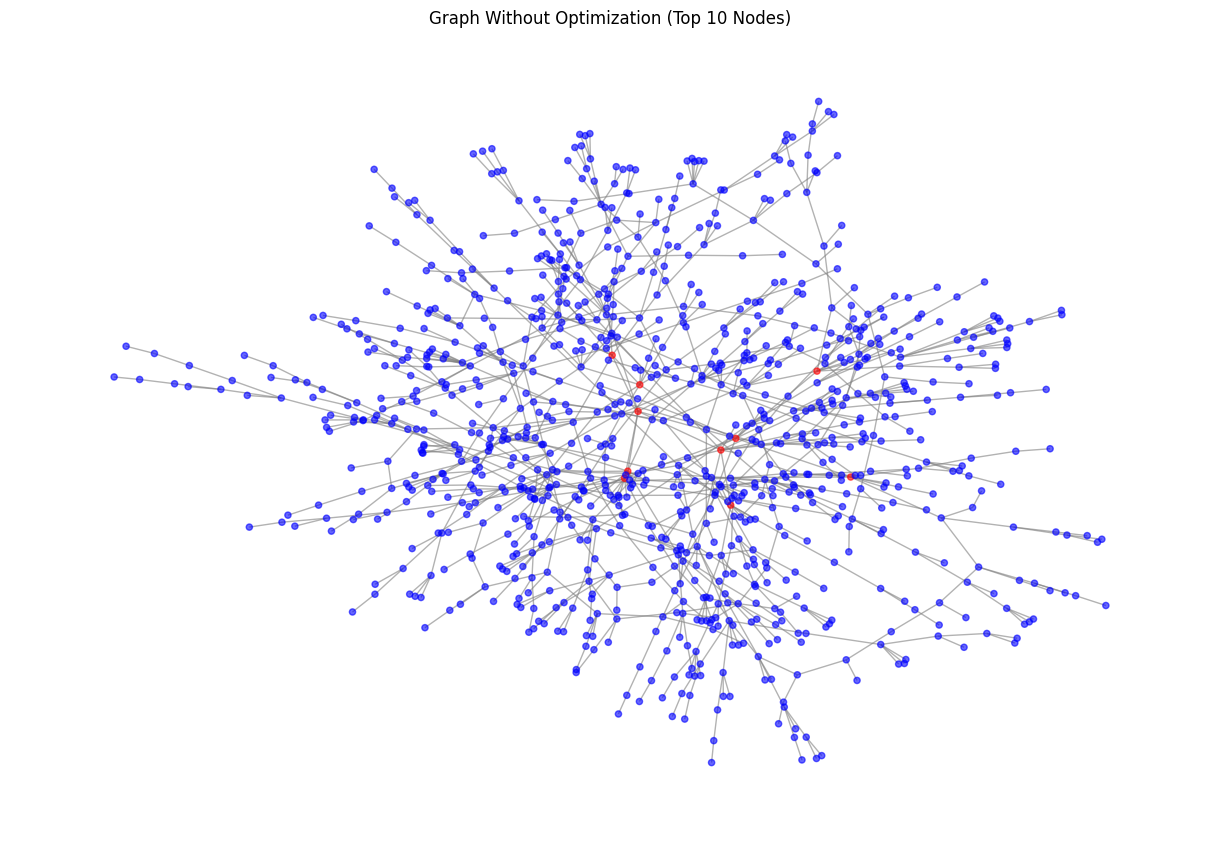


Optimal Weights (Degree, Closeness, Betweenness, Eigenvector): [2.288037347891194, 1.7522632409605066, 2.7490245523598937, 1.9460325933087126]

Top 10 Nodes With Optimization:
Node: 1, Score: 8.27775026494207
Node: 0, Score: 7.369549867755266
Node: 5, Score: 5.945325554104446
Node: 3, Score: 5.494213857049024
Node: 2, Score: 5.2318340068288025
Node: 4, Score: 4.710355072216152
Node: 24, Score: 4.017159113789612
Node: 6, Score: 3.784907534712684
Node: 96, Score: 3.7230612968738392
Node: 37, Score: 3.5745873288668406


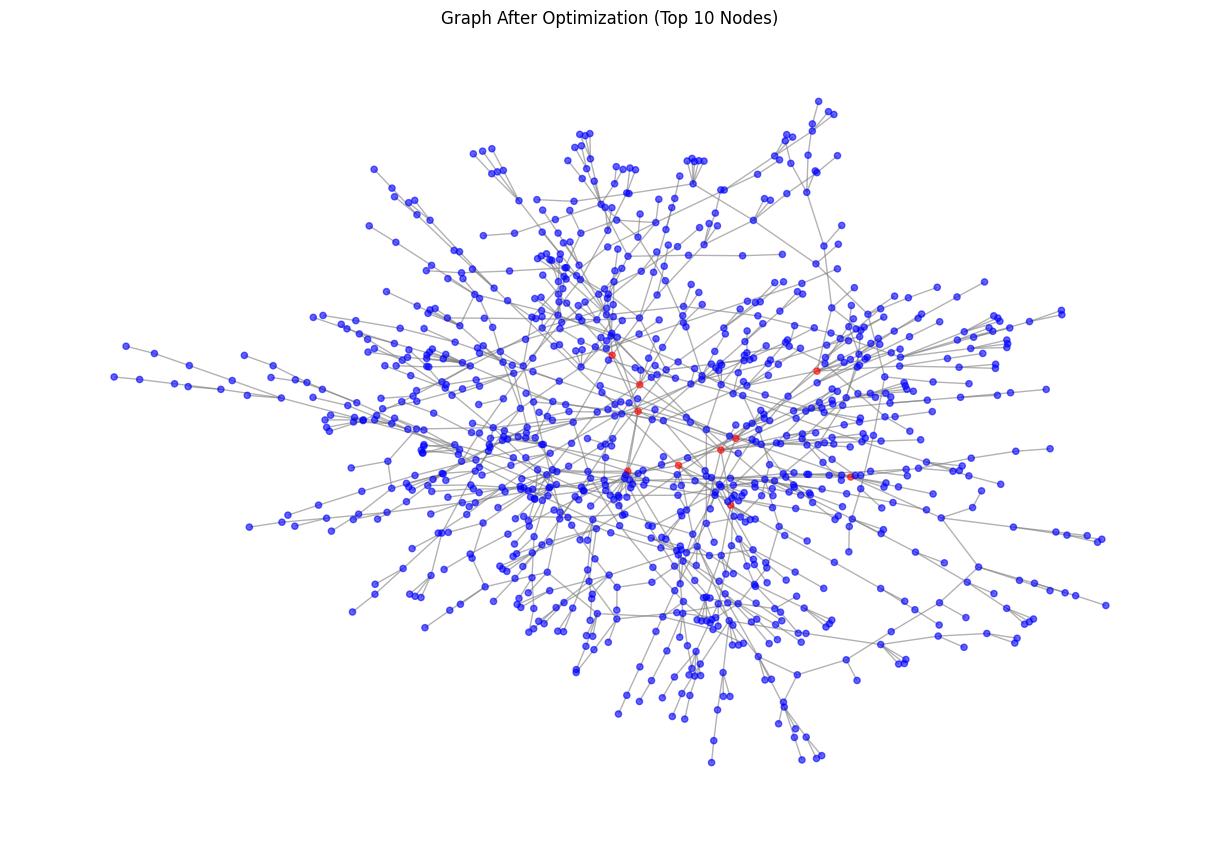

In [43]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

# ---------------------------
# Graph Generation Function
# ---------------------------
def generate_graph(n=1000):
    """
    Generates a connected, undirected, simple graph with n nodes.
    A spanning tree ensures connectivity, and extra random edges are added.
    """
    G = nx.Graph()
    G.add_nodes_from(range(n))

    # Ensure connectivity by forming a spanning tree first
    for i in range(1, n):
        G.add_edge(i, np.random.randint(0, i))

    # Add more random edges
    while G.number_of_edges() < n - 1 + np.random.randint(0, n//2):
        u, v = np.random.randint(0, n, 2)
        if u != v and not G.has_edge(u, v):
            G.add_edge(u, v)

    return G

G = generate_graph()

# ---------------------------
# Centrality Computation Function
# ---------------------------
def compute_centralities(G):
    """
    Computes four centrality measures using NetworkX:
    - Degree Centrality
    - Closeness Centrality
    - Betweenness Centrality
    - Eigenvector Centrality
    """
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G, normalized=True)
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

    return degree_centrality, closeness_centrality, betweenness_centrality, eigenvector_centrality

degree_centrality, closeness_centrality, betweenness_centrality, eigenvector_centrality = compute_centralities(G)

# Normalize centralities
def normalize(d):
    min_val, max_val = min(d.values()), max(d.values())
    return {k: (v - min_val) / (max_val - min_val) if max_val > min_val else 0 for k, v in d.items()}

degree_centrality = normalize(degree_centrality)
closeness_centrality = normalize(closeness_centrality)
betweenness_centrality = normalize(betweenness_centrality)
eigenvector_centrality = normalize(eigenvector_centrality)

# ---------------------------
# Compute Combined Scores
# ---------------------------
def compute_cv(weights):
    """
    Computes a combined centrality score using the given weights.
    """
    w1, w2, w3, w4 = weights
    return {
        node: (w1 * degree_centrality[node] +
               w2 * closeness_centrality[node] +
               w3 * betweenness_centrality[node] +
               w4 * eigenvector_centrality[node])
        for node in G.nodes()
    }

# ---------------------------
# Visualization Function
# ---------------------------
def visualize_graph(G, top_nodes=None, title="Graph Visualization"):
    """
    Draws the graph, optionally highlighting top_nodes in red.
    """
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)

    if top_nodes:
        node_colors = ["red" if node in top_nodes else "blue" for node in G.nodes()]
    else:
        node_colors = "blue"

    nx.draw(G, pos, node_size=20, node_color=node_colors, edge_color="gray", alpha=0.6)
    plt.title(title)
    plt.show()

# ---------------------------
# Step 1: Plot Original Graph
# ---------------------------
visualize_graph(G, title="Original Graph")

# ---------------------------
# Step 2: Compute Scores Without Optimization (Equal Weights)
# ---------------------------
equal_weights = (1, 1, 1, 1)
cv_no_opt = compute_cv(equal_weights)

# Get top 10 nodes before optimization
top_nodes_no_opt = sorted(cv_no_opt.items(), key=lambda x: x[1], reverse=True)[:10]

print("\nTop 10 Nodes Without Optimization:")
for node, score in top_nodes_no_opt:
    print(f"Node: {node}, Score: {score}")

# Plot graph with top 10 nodes before optimization
visualize_graph(G, top_nodes=[node for node, _ in top_nodes_no_opt], title="Graph Without Optimization (Top 10 Nodes)")

# ---------------------------
# Step 3: Optimize Weights Using Genetic Algorithm
# ---------------------------

# Define evaluation function
def evaluate(weights):
    cv = compute_cv(weights)
    scores = list(cv.values())
    return np.std(scores),  # Maximize score variance for better differentiation

# DEAP Setup for GA
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximize std deviation
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=4)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)

# Run Genetic Algorithm
population = toolbox.population(n=20)
NGEN = 50
for gen in range(NGEN):
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.2)
    fits = list(map(toolbox.evaluate, offspring))
    for ind, fit in zip(offspring, fits):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

# Get Best Weights
best_individual = tools.selBest(population, k=1)[0]
best_weights = best_individual
cv_opt = compute_cv(best_weights)

print("\nOptimal Weights (Degree, Closeness, Betweenness, Eigenvector):", best_weights)

# ---------------------------
# Step 4: Compute Scores After Optimization
# ---------------------------
top_nodes_opt = sorted(cv_opt.items(), key=lambda x: x[1], reverse=True)[:10]

print("\nTop 10 Nodes With Optimization:")
for node, score in top_nodes_opt:
    print(f"Node: {node}, Score: {score}")

# ---------------------------
# Step 5: Plot Graph After Optimization
# ---------------------------
visualize_graph(G, top_nodes=[node for node, _ in top_nodes_opt], title="Graph After Optimization (Top 10 Nodes)")
